**1. Import needed library**

In [ ]:
import numpy as np
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os
from google.colab import drive
#cnn library
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet201
from keras.applications.densenet import preprocess_input
from keras import layers
import keras
import tensorflow as tf
#rating library
from sklearn.metrics import confusion_matrix, accuracy_score, auc, matthews_corrcoef, roc_curve, roc_auc_score
import itertools
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [ ]:
import keras.backend as K


In [ ]:
from sklearn.metrics import f1_score, mean_absolute_error
from sklearn.preprocessing import label_binarize
from scipy import interp

**2.Config global parameter**

In [ ]:
plt.style.use('fivethirtyeight')
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

**3. Load Images**

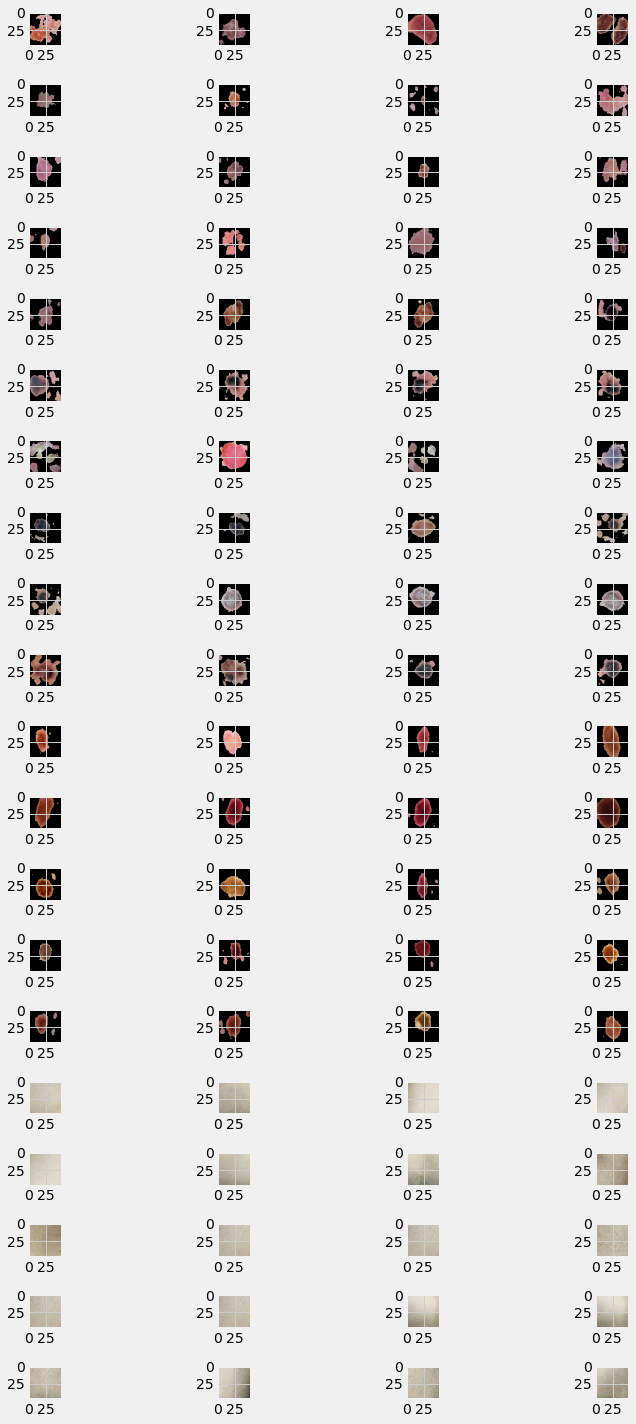

In [ ]:
# Set path to specific dataset
base_path = '/content/drive/My Drive/FinalProjectRepo/DATASET_PREPROCESSED_NEWER'
pigmented_dataset_path = '/content/drive/My Drive/FinalProjectRepo/DATASET_PREPROCESSED_NEWER/pigmented'
carcinoma_dataset_path = '/content/drive/My Drive/FinalProjectRepo/DATASET_PREPROCESSED_NEWER/carcinoma'
melanoma_dataset_path = '/content/drive/My Drive/FinalProjectRepo/DATASET_PREPROCESSED_NEWER/melanoma'
normal_dataset_path = '/content/drive/My Drive/FinalProjectRepo/DATASET_PREPROCESSED_NEWER/normal'
# List all images of each dataset
pigmented_images = os.listdir(pigmented_dataset_path)
carcinoma_images = os.listdir(carcinoma_dataset_path)
melanoma_images = os.listdir(melanoma_dataset_path)
normal_images = os.listdir(normal_dataset_path)
# Set picture size: 100
pic_size = 48
# Set plot to visualize loaded image
plt.figure(0, figsize=(12,20))
cpt = 0
image_paths = []
image_labels = []
for i in pigmented_images[0:20]:
  image_paths.append(os.path.join(pigmented_dataset_path, i))
  image_labels.append(0)
for i in carcinoma_images[0:20]:
  image_paths.append(os.path.join(carcinoma_dataset_path, i))
  image_labels.append(1)
for i in melanoma_images[0:20]:
  image_paths.append(os.path.join(melanoma_dataset_path, i))
  image_labels.append(2)
for i in normal_images[0:20]:
  image_paths.append(os.path.join(normal_dataset_path, i))
  image_labels.append(3)  
for image_path in image_paths:
  cpt = cpt + 1
  plt.subplot(20,4,cpt)
  if os.path.isfile(image_path):
    img = load_img(image_path, target_size=(pic_size, pic_size))
    plt.imshow(img, cmap="gray")     
plt.tight_layout()
plt.show()

**4. Data generator**

In [ ]:
# count number of train images for each disease
for disease in os.listdir(base_path):
    print(str(len(os.listdir(base_path + "/" + disease))) + " " + disease + " images")
# number of images to feed into the NN for every batch

batch_size = 32
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)
train_generator = datagen.flow_from_directory(directory=base_path,
                                                    target_size=(256,256),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset="training",
                                                    shuffle=True)

validation_generator = datagen.flow_from_directory(directory=base_path,
                                                    target_size=(256,256),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset="validation",
                                                    shuffle=False)


522 normal images
1056 pigmented images
1201 melanoma images
1186 carcinoma images
Found 3173 images belonging to 4 classes.
Found 792 images belonging to 4 classes.


**4. Setup CNN**

In [ ]:
#  with strategy.scope():
#   nb_classes = 4 
#   model = DenseNet201(
#       include_top=True, input_tensor=None, weights=None,
#       input_shape=(224, 224, 3), pooling='avg', classes=nb_classes
#   )
#   opt = tf.optimizers.Adam(0.001)
#   model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
nb_classes = 4


pre_trained_model = DenseNet201(
    include_top=False,weights='imagenet', input_shape=(256, 256, 3)
)
for layer in pre_trained_model.layers:
    if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
        layer.trainable = True
        K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
        K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
    else:
        layer.trainable = False
last_layer = pre_trained_model.get_layer('relu')
last_output = last_layer.output
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.7
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(4, activation='softmax')(x)

# Configure and compile the model

model = Model(pre_trained_model.input, x)
optimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

**5. Train the model**

In [ ]:
# number of epochs to train the NN
epochs = 150
checkpoint = ModelCheckpoint("/content/drive/MyDrive/FinalProjectRepo/FinalProject/model/cnn/checkpoint/model_weights_densenet_segment_finetune_score.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint, learning_rate_reduction]
# model.load_weights("/content/drive/MyDrive/FinalProjectRepo/FinalProject/model/cnn/checkpoint/model_weights_densenet201_segment.h5")
history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=train_generator.n//train_generator.batch_size,
                                epochs=epochs,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.n//validation_generator.batch_size,
                                callbacks=callbacks_list
                                )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
99/99 [==============================] - 561s 6s/step - loss: 15.5049 - accuracy: 0.5023 - val_loss: 4.2373 - val_accuracy: 0.3008

Epoch 00001: val_accuracy improved from -inf to 0.30078, saving model to /content/drive/MyDrive/FinalProjectRepo/FinalProject/model/cnn/checkpoint/model_weights_densenet_segment_finetune_score.h5
Epoch 2/150
99/99 [==============================] - 67s 672ms/step - loss: 1.0660 - accuracy: 0.7330 - val_loss: 1.4236 - val_accuracy: 0.5169

Epoch 00002: val_accuracy improved from 0.30078 to 0.51693, saving model to /content/drive/MyDrive/FinalProjectRepo/FinalProject/model/cnn/checkpoint/model_weights_densenet_segment_finetune_score.h5
Epoch 3/150
99/99 [==============================] - 67s 676ms/step - loss: 1.2700 - accuracy: 0.7041 - val_loss: 1.4239 - val_accuracy: 0.4466

Epoch 00003: val_accuracy did not improve from 0.51693
Epoch 4/150
99/99 [==============================] - 66s 660ms/step - loss: 0.6196 - accuracy: 0.7485 - val_loss: 0.

**Save the model to JSON file**

In [ ]:
# serialize model structure to JSON
model_json = model.to_json()
with open("/content/drive/MyDrive/FinalProjectRepo/FinalProject/model/cnn/densenet_segment_finetune_score/cnn_model_densenet_segment_finetune.json", "a") as json_file:
    json_file.write(model_json)
model.save('/content/drive/MyDrive/FinalProjectRepo/FinalProject/model/cnn/densenet_segment_finetune_score')   

INFO:tensorflow:Assets written to: /content/drive/MyDrive/FinalProjectRepo/FinalProject/model/cnn/densenet_segment_finetune_score/assets


**Load Model**

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/FinalProjectRepo/FinalProject/model/cnn/desenet_segment')

**Analyse the result**

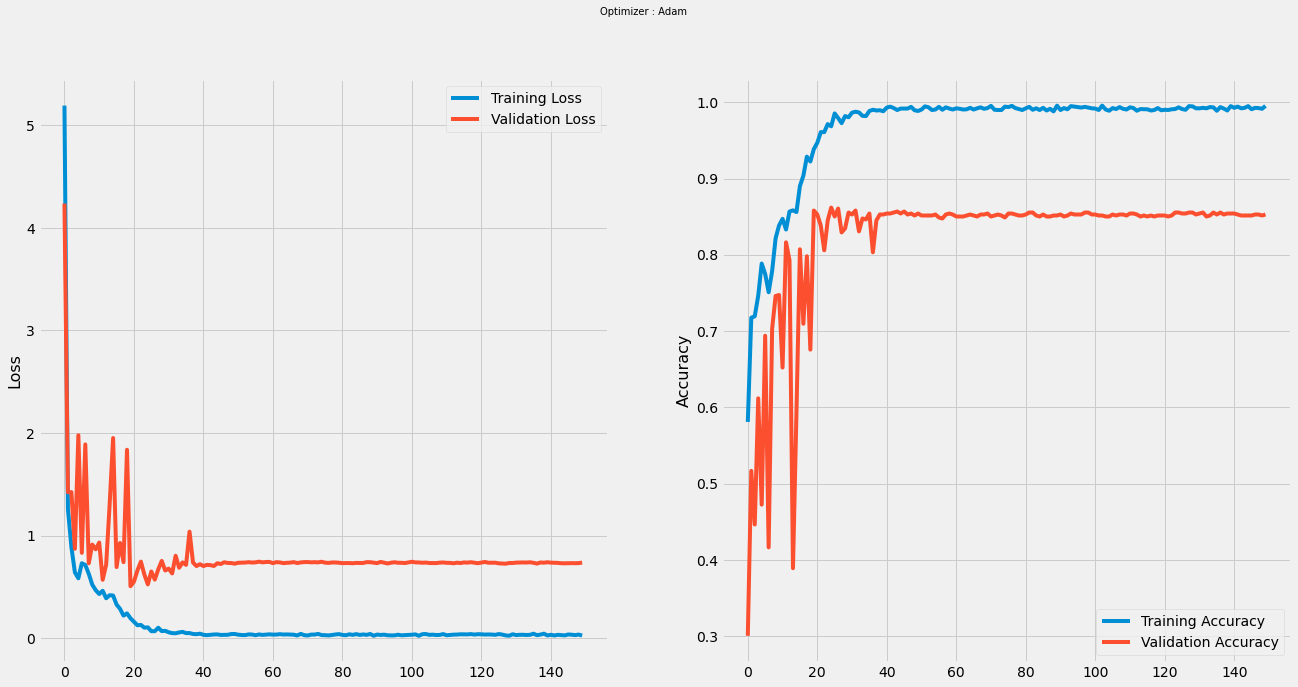

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

**Confuse Matrix**

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


<Figure size 432x288 with 0 Axes>

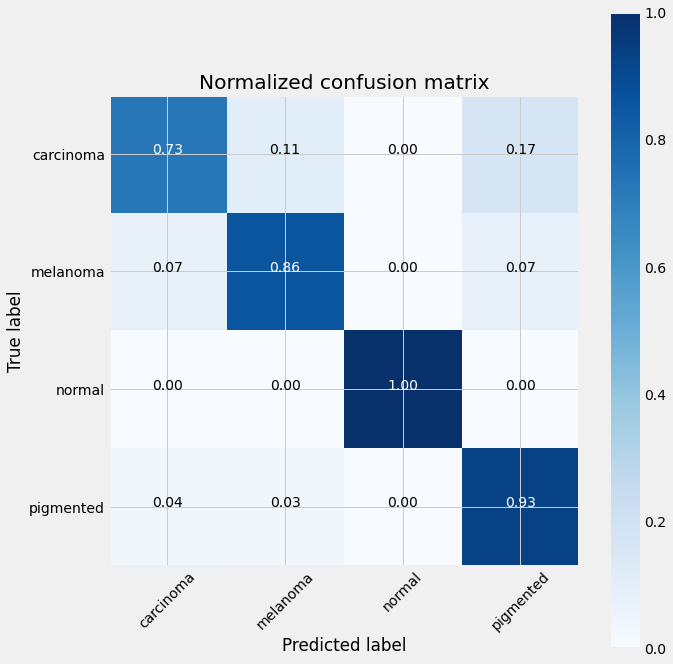

In [ ]:
# show the confusion matrix of our predictions
# compute predictions
predictions = model.predict_generator(generator=validation_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = validation_generator.classes
class_names = validation_generator.class_indices.keys()

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

**Calculate ACC, AUC, MCC, ROC curve**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


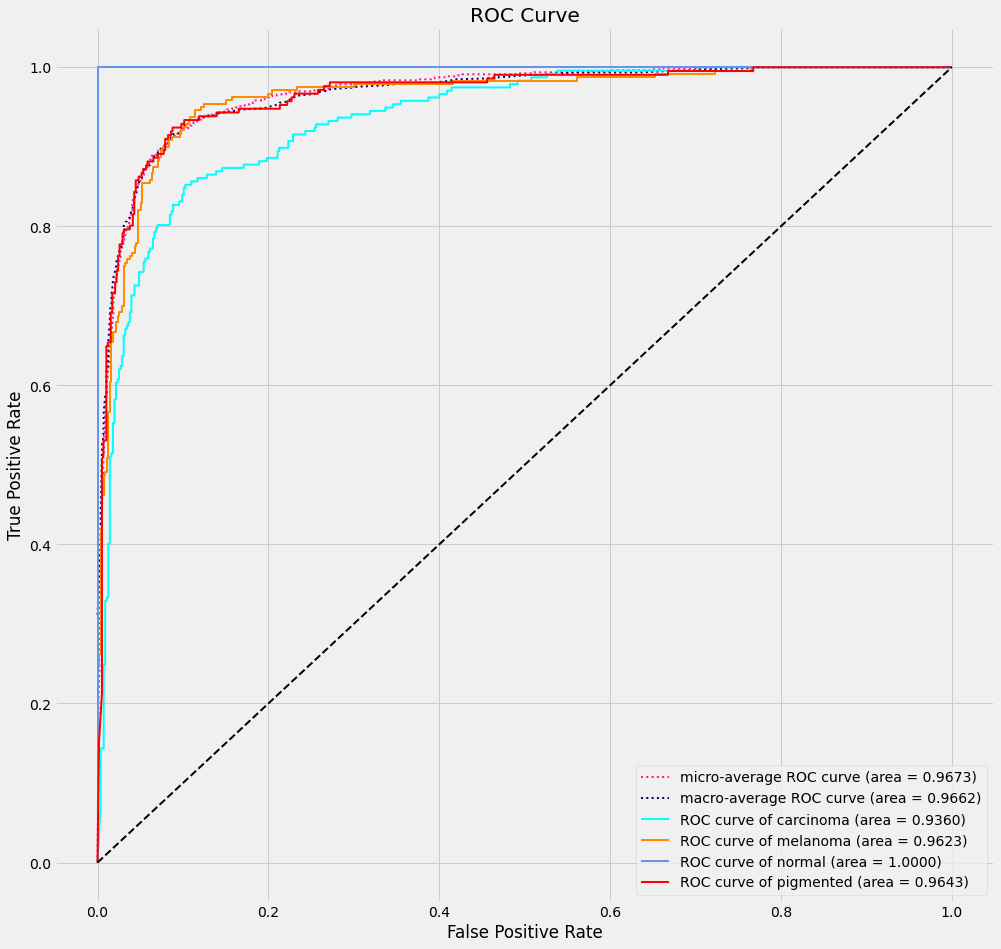

In [ ]:
y_prob = [np.max(probas) for probas in predictions]
y_test = label_binarize(y_test, classes=[0, 1, 2, 3])
lw = 2
names = [*class_names]
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], predictions[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(4):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 4

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
plt.figure(figsize=(15,15))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=lw)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=lw)
colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])

for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (area = {1:0.4f})'
             ''.format(names[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:

y_test = validation_generator.classes
y_pred = [np.argmax(probas) for probas in predictions]
for i in range(4):
  print("AUC for {}: {}".format(names[i], roc_auc[i]))
print("AUC for {}: {}".format('Macro', roc_auc['macro']))  
print("AUC for {}: {}".format('Micro', roc_auc['micro'])) 
print("MCC: {}".format(matthews_corrcoef(y_test, y_pred)))
print("F1 Macro: {}".format(f1_score(y_test, y_pred, average='macro')))
print("F1 Micro: {}".format(f1_score(y_test, y_pred, average='micro')))
print("F1 Weighted: {}".format(f1_score(y_test, y_pred, average='weighted')))
print("MEA: {}".format(mean_absolute_error(y_test, y_pred)))

AUC for carcinoma: 0.936032234766412
AUC for melanoma: 0.9623037439613525
AUC for normal: 1.0
AUC for pigmented: 0.9643326182183032
AUC for Macro: 0.9662180126039785
AUC for Micro: 0.9672979266571438
MCC: 0.8063611903192848
F1 Macro: 0.8748447501274912
F1 Micro: 0.8560606060606061
F1 Weighted: 0.8547639898207824
MEA: 0.29545454545454547


In [ ]:
loss_val, acc_val = model.evaluate_generator(train_generator)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))
loss_test, acc_test = model.evaluate_generator(validation_generator)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Validation: accuracy = 0.999685  ;  loss_v = 0.008797
Test: accuracy = 0.856061  ;  loss = 0.725338


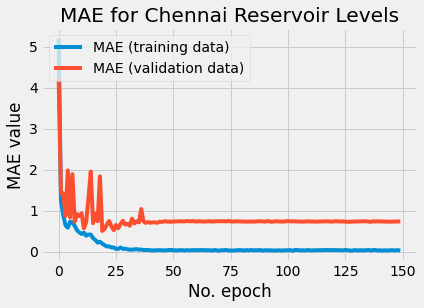

In [ ]:
# Plot history: MAE
plt.plot(history.history['loss'], label='MAE (training data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('MAE for Chennai Reservoir Levels')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()